In [1]:
import os
import errno
import numpy as np 
import xarray as xr
import deepcell
from deepcell.applications import MultiplexSegmentation

In [2]:
# load data
data_dir = '/data/segmentation/20200227_IF_Testing/melanoma/'
#data_dir = '/data/alex/2020325_test_image/'
data_dir = '/data/segmentation/20200227_IF_Testing/test_data/eliot'
data_dir = '/data/segmentation/20200209_CyCIF/'
data_dir = '/data/segmentation/datasets/20200226_Melanoma/20200627_Melanoma'
#data_dir = '/data/segmentation/datasets/20200114_cHL/20200522_cHL_job/'
data_dir = '/data/segmentation/datasets/20191219_Eliot/20200616_Eliot_Screen2/'
#data_dir = '/data/segmentation/20200616_Model_Assessment'
# data_dir = '/data/selena/20200703_GI_test/'
# data_dir = '/data/segmentation/datasets/20200219_Roshan/20200720_Roshan/'
data_dir = '/data/segmentation/20200413_Human_Agreement'
#data_dir = '/data/segmentation/20200820_figure_2_data/'
# data_dir = '/data/segmentation/20200831_figure_4'
#data_dir = '/data/segmentation/20200811_subcellular_loc/'
data_dir = '/data/segmentation/datasets/20200424_TB/'
#data_dir = '/data/segmentation/datasets/20200520_HIV'
#data_dir = '/data/segmentation/datasets/20200210_CyCIF_Tonsil/20201001_CyCIF_Tonsil'
#data_dir = '/data/segmentation/datasets/20200116_DCIS/20200618_DCIS'
# data_dir = '/data/segmentation/datasets//20200114_cHL/20201018_cHL/'



# data_dir = '/data/segmentation/datasets/20200526_COH_BC/20200730_COH_BC'
# data_dir = '/data/segmentation/datasets/20200624_graham_pancreas/'
# data_dir = '/data/segmentation/datasets/20200624_CODEX_Panc/20200823_CODEX_Panc'
# data_dir = '/data/segmentation/datasets/20200627_CODEX_CRC/20200919_CODEX_CRC'
# data_dir = '/data/segmentation/datasets/20200209_CyCIF/20200804_CyCIF_BRCA'
#data_dir = '/data/segmentation/datasets/20201003_nuc_starter'
data_dir = '/data/segmentation/20200413_Human_Agreement/'
data_dir = '/data/segmentation/20201027_3D_mousebrain'


In [2]:
test_data = np.load('/data/npz_data/20201018_freeze/20201018_multiplex_seed_1_test_256x256.npz')

In [5]:
test_data = np.load(data_dir + '/combined.npz')

In [6]:
X_test = test_data['X']

In [37]:
cohort_xr = xr.open_dataarray(os.path.join(data_dir,'cimac_deepcell_input.xr'))
cohort_xr.shape

(16, 1024, 1024, 2)

In [4]:
vals = np.zeros(list(cohort_xr.shape[:-1]) + [2])
vals[:, :, :, 0] = cohort_xr.values[..., 0]

In [18]:
vals = np.zeros(list(test_data.shape[:-1]) + [2])
vals[:, :, :, 0] = test_data[..., 0]

In [21]:
app = MultiplexSegmentation(use_pretrained_weights=False)

In [22]:
# compartment
weights = "/data/models/20200619_production_updates/20200908_multiplex__nuclear__deep_watershed.h5"

In [23]:
app.model.load_weights(weights)

In [49]:
output = app.predict(image=cohort_xr.values, image_mpp=0.5, compartment='nuclear', 
                     postprocess_kwargs_whole_cell={'maxima_threshold': 0.1, 'maxima_model_smooth': 0,
                                                   'interior_model_smooth': 2, 'interior_threshold': 0.4,
                                                   'small_objects_threshold': 10,
                                                   'fill_holes_threshold': 10,
                                                   'radius': 3,
                                                   'pixel_expansion': 2}, 
                     postprocess_kwargs_nuclear={'interior_threshold': 0.3, 'interior_model_smooth': 1,
                                                'maxima_model_smooth': 0, 'maxima_threshold':0.1, 'radius': 3,
                                                'small_objects_threshold': 10,
                                                'fill_holes_threshold': 10,})

In [56]:
output = app.predict(image=cohort_xr.values, image_mpp=0.5, compartment='nuclear',  
                     postprocess_kwargs_nuclear={'interior_threshold': 0.3, 'interior_model_smooth': 1,
                                                'maxima_threshold':0.1, 'maxima_model_smooth': 0,
                                                  'radius': 3,
                                                  'small_objects_threshold': 10,
                                                  'fill_holes_threshold': 10,
                                                'pixel_expansion': 3,})

In [7]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            if np.sum(input_data[img, :, :, channel] > 0):
                percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                                [0, 95])
                rescaled_intensity = rescale_intensity(input_data[img, :, :, channel].astype('float32'),
                                                           in_range=(percentiles[0], percentiles[1]),
                                                           out_range='float32')
                RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [10]:
RGB_data = make_color_overlay(cohort_xr.values)

In [57]:
predicted_overlay = make_outline_overlay(RGB_data, output[:10, :, :, 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Predicted Overlay')

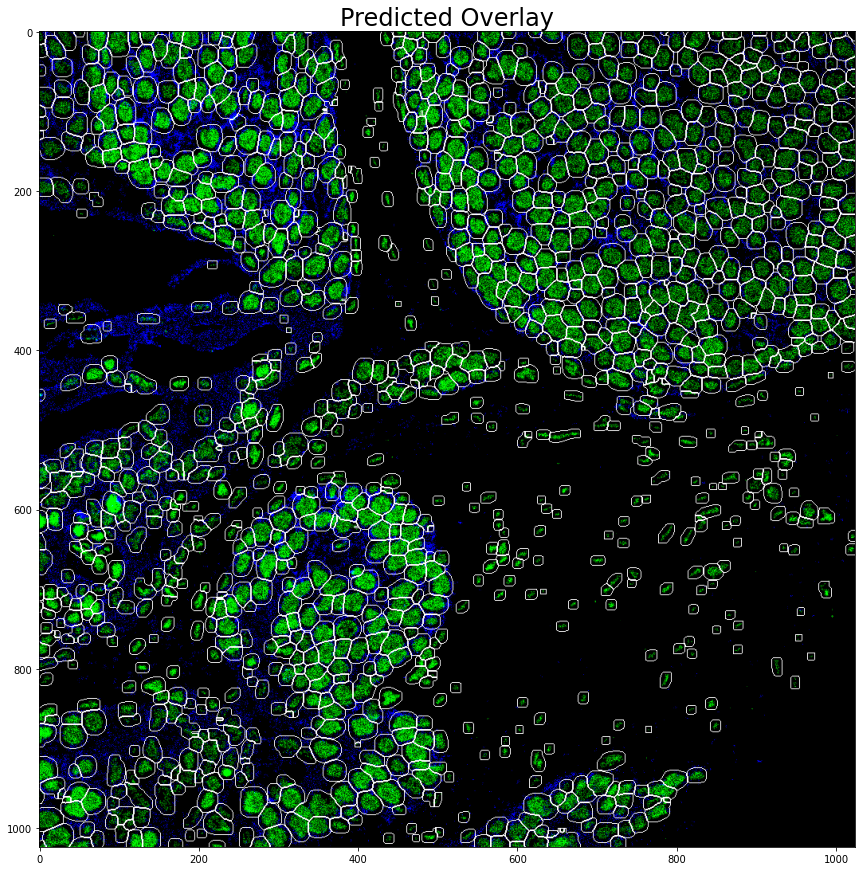

In [60]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 9
fig, axes = plt.subplots(figsize=(20,15))

axes.imshow(predicted_overlay[index, :, :, :], cmap=cmap)

axes.set_title('Predicted Overlay', fontsize=24)

In [67]:
np.unique(test_data['tissue_list'], return_counts=True)

(array(['breast', 'gi', 'immune', 'pancreas', 'skin'], dtype='<U8'),
 array([202, 215,  20, 305,  36]))

In [61]:
segmentation_labels = xr.DataArray(output,
                         coords=[cohort_xr.coords['fovs'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['nuclear']],
                         dims=['fovs', 'rows', 'cols', 'compartments'])
segmentation_labels.to_netcdf(os.path.join(data_dir, "segmentation_labels_nuc_expansion.xr"), format="NETCDF3_64BIT")

## for whole-cell only model

In [3]:
weights = '/data/models/20200619_production_updates/20200930_multiplex_deep_watershed.h5'

In [19]:
weights = '/data/models/20200619_production_updates/20201018_multiplex_seed_1__nuclear_deep_watershed.h5'

In [8]:
weights = '/data/analyses/specialist_benchmarking/20201018_multiplex_seed_1_subset_100_all.h5'

In [9]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256,256, 2),
    norm_method=None,
    num_semantic_heads=2,
    num_semantic_classes=[1, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True,
    use_imagenet=False)

W1028 00:40:06.991699 140643130197824 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.load_weights(weights)

In [11]:
from deepcell.applications import MultiplexSegmentation
from deepcell_toolbox.utils import tile_image, untile_image
from deepcell_toolbox.multiplex_utils import multiplex_preprocess
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
app = MultiplexSegmentation(use_pretrained_weights=False)

In [13]:
preprocessed = multiplex_preprocess(X_test[2:-2, ...])
resized = app._resize_input(preprocessed, image_mpp=0.5)
tiled_data, tile_info = tile_image(resized, model_input_shape=(256, 256), stride_ratio=1)

In [14]:
model_output = model.predict(tiled_data)
inner_distance, pixelwise = app._untile_output(model_output, tile_info)

In [79]:
# cell predictions
predictions = deep_watershed_mibi({'inner-distance':inner_distance,
                                  'pixelwise-interior': pixelwise[..., 1:2]},
                                  maxima_threshold=0.17, maxima_model_smooth=5,
                                  interior_threshold=0.3,
                                  interior_model_smooth=2,
                                  radius=3,
                                  small_objects_threshold=10,
                                  fill_holes_threshold=10,
                                   pixel_expansion=0)

In [28]:
# nuc predictions
predictions = deep_watershed_mibi({'inner-distance':inner_distance,
                                  'pixelwise-interior': pixelwise[..., 1:2]},
                                  maxima_threshold=0.1, maxima_model_smooth=0,
                                  interior_threshold=0.3,
                                  interior_model_smooth=2,
                                  radius=3,
                                  small_objects_threshold=10,
                                  fill_holes_threshold=10,
                                   pixel_expansion=3)

In [26]:
predictions = app._resize_output(predictions, cohort_xr.shape)

NameError: name 'cohort_xr' is not defined

In [17]:
RGB_data = make_color_overlay(X_test[2:-2, ..., :])

In [80]:
predicted_overlay = make_outline_overlay(RGB_data, predictions[:, :, :, 0])

In [44]:
cohort_xr.fovs[23]

<xarray.DataArray 'fovs' ()>
array('Point7_crop_3', dtype='<U13')
Coordinates:
    fovs     <U13 'Point7_crop_3'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Predicted Overlay')

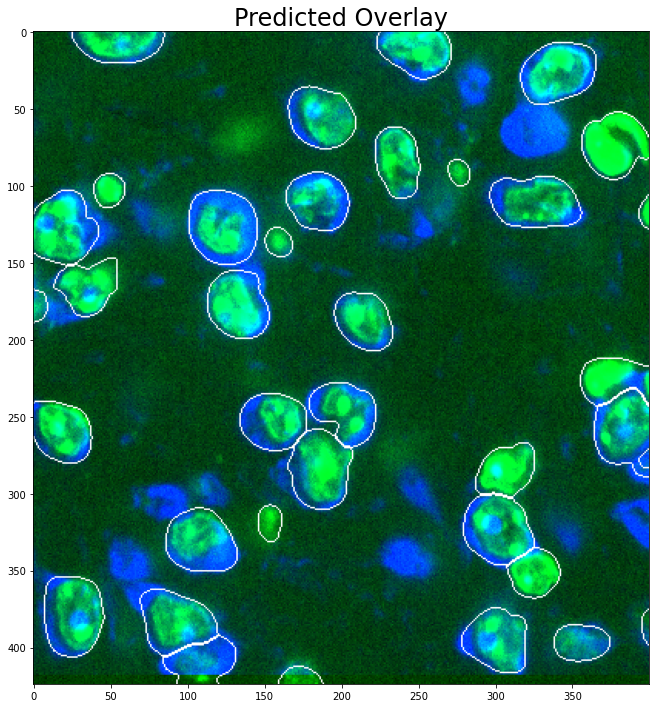

In [91]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 25
fig, axes = plt.subplots(figsize=(12,12))

axes.imshow(predicted_overlay[index, 600:, 200:600, :], cmap=cmap)

axes.set_title('Predicted Overlay', fontsize=24)

In [56]:
segmentation_labels = xr.DataArray(predictions,
                         coords=[cohort_xr.coords['fovs'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['whole_cell']],
                         dims=['fovs', 'rows', 'cols', 'compartments'])
segmentation_labels.to_netcdf(os.path.join(data_dir, "segmentation_labels.xr"), format="NETCDF3_64BIT")

In [32]:
# for test data evaluation
np.savez_compressed('/data/segmentation/20201022_test_split/20201018_multiplex_seed_1_test_nuc_expansion.npz', y=predictions)